<ipython-input-1-6bf6b2dbdcde>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2015-01-01', periods=120, freq='M')  # 10 years of monthly data
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
<ipython-input-1-6bf6b2dbdcde>:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='M')


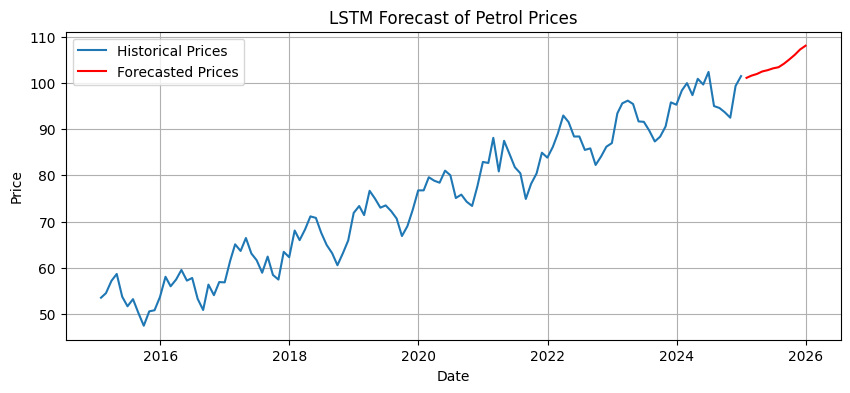

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Step 1: Create synthetic petrol price data
np.random.seed(42)
dates = pd.date_range(start='2015-01-01', periods=120, freq='M')  # 10 years of monthly data
trend = np.linspace(50, 100, 120)
seasonal = 5 * np.sin(2 * np.pi * dates.month / 12)
noise = np.random.normal(0, 2, 120)
prices = trend + seasonal + noise

df = pd.DataFrame({'Date': dates, 'Petrol_Price': prices})
df.set_index('Date', inplace=True)

# Step 2: Normalize the data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(df[['Petrol_Price']])

# Step 3: Prepare sequences for LSTM (sliding window)
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_dataset(scaled_prices, window_size)

# Reshape input for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Step 4: Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Step 5: Train the model
model.fit(X, y, epochs=100, verbose=0)

# Step 6: Forecast future prices
forecast_input = scaled_prices[-window_size:]  # last window
predictions = []
n_forecast = 12

for _ in range(n_forecast):
    input_reshaped = forecast_input.reshape((1, window_size, 1))
    pred = model.predict(input_reshaped, verbose=0)
    predictions.append(pred[0, 0])
    forecast_input = np.append(forecast_input[1:], pred[0, 0])

# Inverse transform to get actual price
forecasted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Step 7: Plot
forecast_dates = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='M')

plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Petrol_Price'], label='Historical Prices')
plt.plot(forecast_dates, forecasted_prices, color='red', label='Forecasted Prices')
plt.title("LSTM Forecast of Petrol Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
